**1. Generate a real chirp signal. Compute the subband decomposition of this
signal upto three levels and plot the approximate and detail components.**

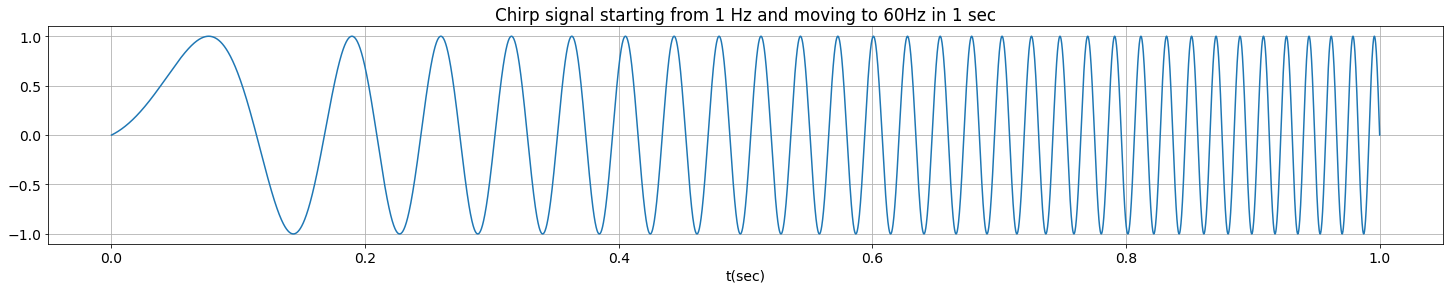

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# https://en.wikipedia.org/wiki/Chirp#:~:text=A%20chirp%20is%20a%20signal,as%20in%20spread%2Dspectrum%20communications.

phiO=0    # the variables are used as per the equation given in the above link
f1=1    #starting frequency
f2=60   # ending frequency
T=1     # duration
fs=100*f2

c=(f2-f1)/T
t=np.linspace(0,T,fs*T)
phi_t= phiO + 2*np.pi*((c/2)*(t**2) + f1*t)
chirp=np.sin(phi_t)


plt.rcParams.update({'font.size':14})
plt.figure(figsize=(25,4))
plt.plot(t,chirp)
plt.xlabel('t(sec)')
plt.title(f'Chirp signal starting from {f1} Hz and moving to {f2}Hz in {T} sec')
plt.grid()
plt.show()

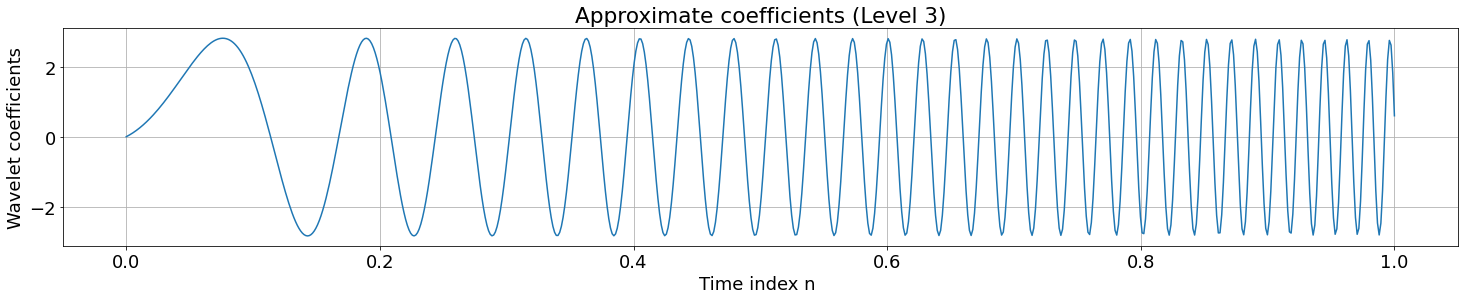

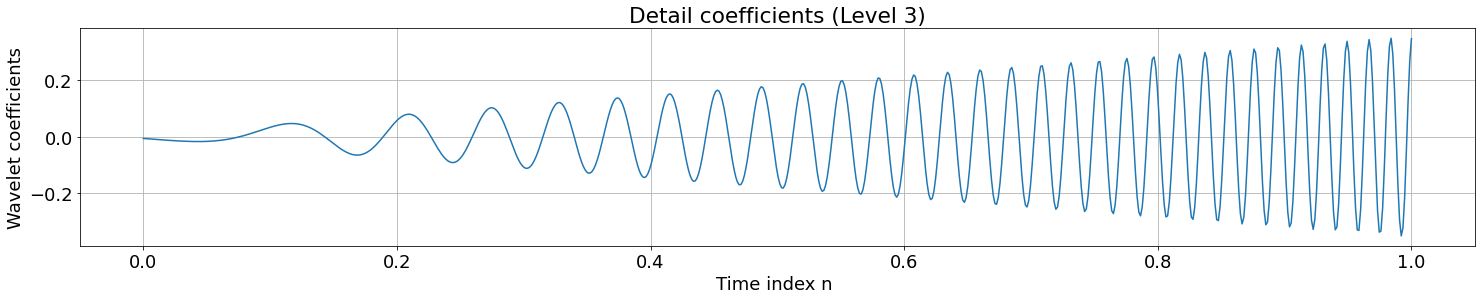

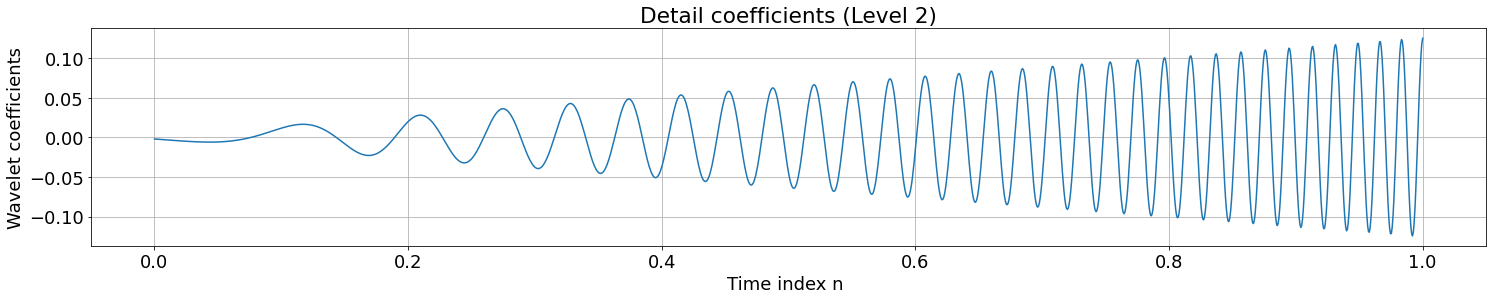

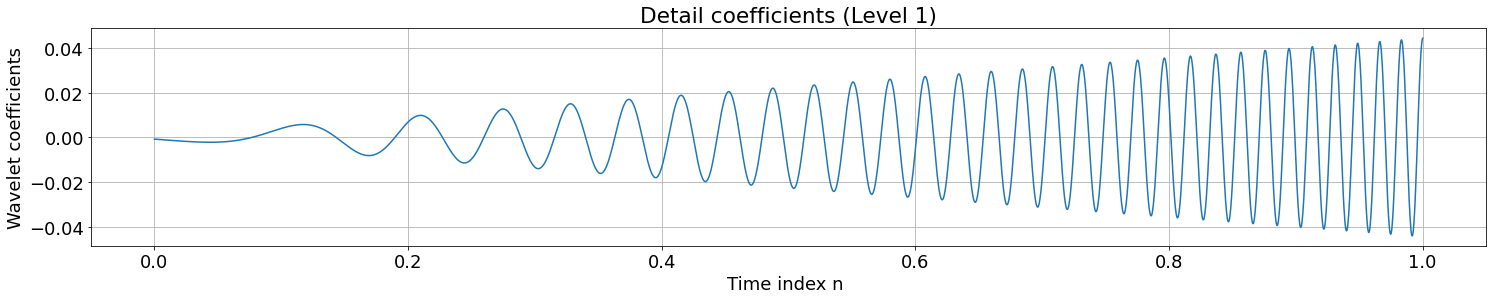

In [71]:
# 3 LEVEL WAVELET DECOMPOSITION

import pywt

db1 = pywt.Wavelet('db1')   # defining mother wavelet as Daubechies1
#print(np.shape(chirp))
ca3, cd3, cd2, cd1=pywt.wavedec(list(chirp), db1, level=3) # 3 level decomposition

c=[ca3, cd3, cd2, cd1]

for (i,coeff) in enumerate(c):            # plotting each subband level coefficients with time
  n=np.linspace(0,1,np.shape(coeff)[0])
  plt.rcParams.update({'font.size':18})
  plt.figure(figsize=(25,4))
  plt.plot(n,coeff)
  plt.xlabel('Time index n ')
  plt.ylabel('Wavelet coefficients')
  if i==0:
    plt.title(f'Approximate coefficients (Level 3)')
  if i==1:
    plt.title(f'Detail coefficients (Level 3)')
  if i==2:
    plt.title(f'Detail coefficients (Level 2)')
  if i==3:
    plt.title(f'Detail coefficients (Level 1)')
  plt.grid()
  plt.show()

The reconstruction using approximate level very closely resembles the original signal. 

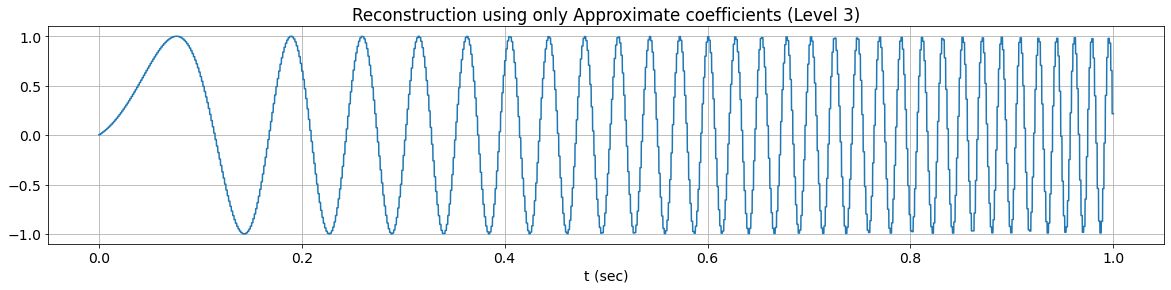

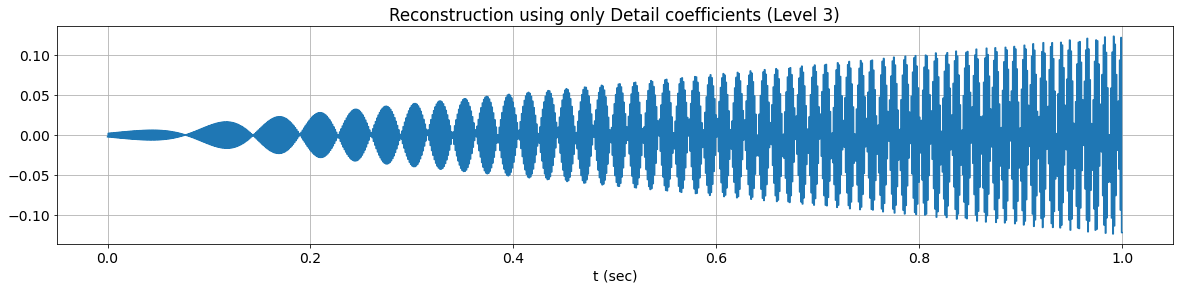

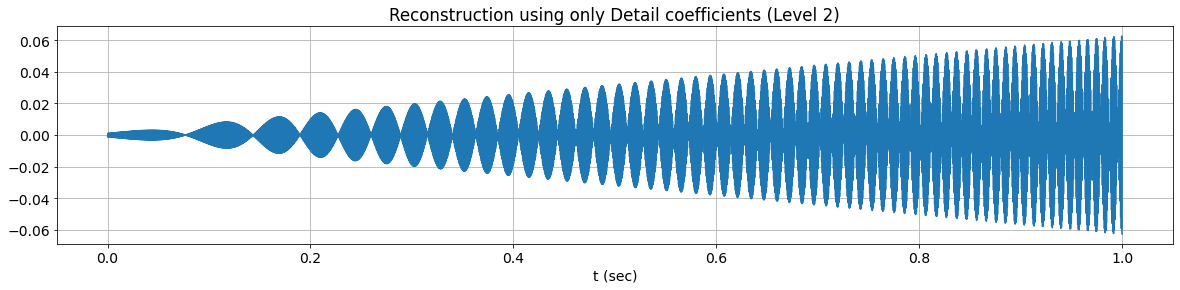

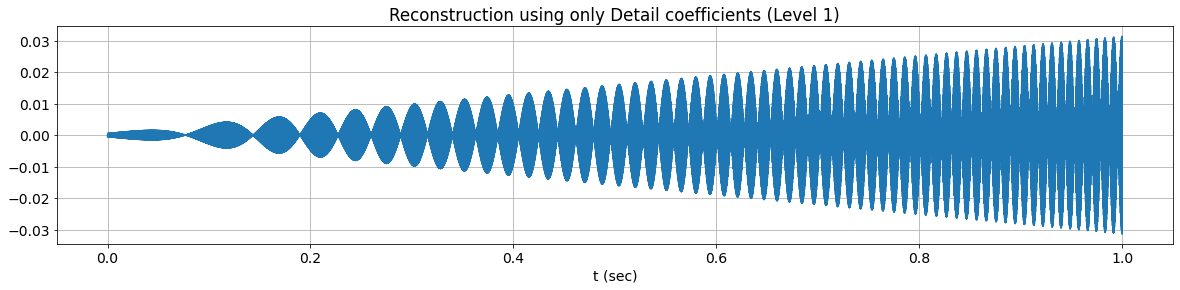

In [58]:
# RECONSTRUCTING USING ONLY ONE OF THE SUBBANDS

for i in range(len(c)): # running a loop over all the subbands. we consider only 
  L=len(c)              # one level as nonzero and the rest zero
  c_hat=[]
  for j in range(L):
    x=np.ndarray(shape=np.shape(c[j]))
    for k in range(np.shape(c[j])[0]):
      if i==j:
        x[k]=c[j][k]
      else: 
        x[k]=0
    c_hat.append(x)

  chirp_hat = pywt.waverec(c_hat,db1) # taking idwt of the coefficients
  plt.figure(figsize=(20,4))
  plt.rcParams.update({'font.size':14})
  plt.plot(t,chirp_hat)
  plt.xlabel('t (sec)')
  plt.grid()
  if i==0:
    plt.title(f'Reconstruction using only Approximate coefficients (Level 3)')
  if i==1:
    plt.title(f'Reconstruction using only Detail coefficients (Level 3)')
  if i==2:
    plt.title(f'Reconstruction using only Detail coefficients (Level 2)')
  if i==3:
    plt.title(f'Reconstruction using only Detail coefficients (Level 1)')
  plt.show()


**2. Consider the sample HeaviSine signal in PyWavelets library. The signal
is added with AWGN and a noisy signal is generated with SNR of 15 dB.
(a) Perform Wavelet decomposition on this signal.
(b) Use an appropriate thresholding method to denoise the signal.
(c) Reconstruct the signal and compare it with the original signal.**

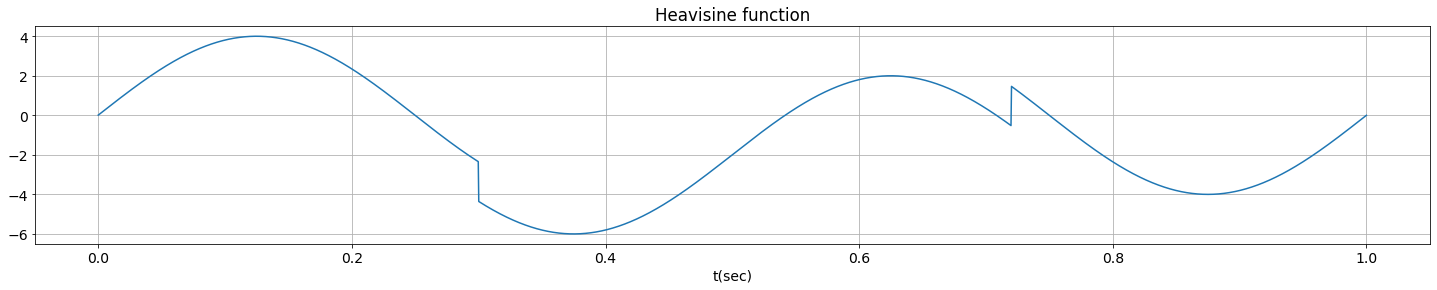

In [59]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

N=5000          # number of data points to consider
heav=pywt.data.demo_signal(name='Heavisine',n=N)    # using the signal from library
#heav=np.reshape(heav,(N,1))
t=np.linspace(0,1,N)
plt.rcParams.update({'font.size':14})
plt.figure(figsize=(25,4))
plt.plot(t,heav)
plt.xlabel('t(sec)')
plt.title(f'Heavisine function')
plt.grid()
plt.show()

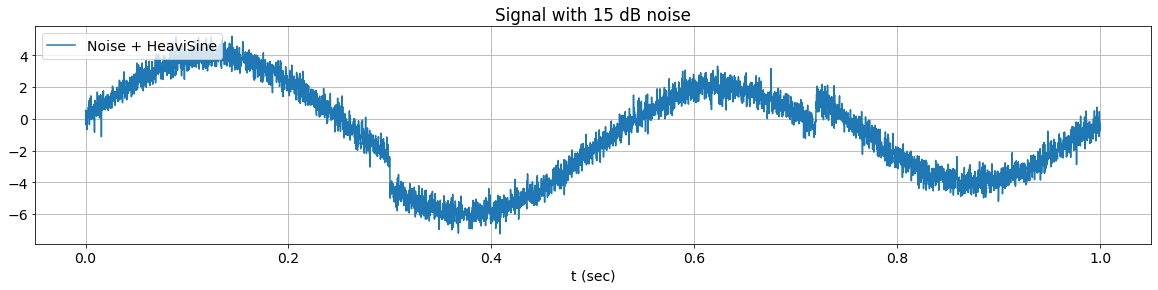

Noise power in db = -6.793257389269433
Signal power in db = 8.206742610730567


In [60]:
# ADDING 15 dB NOISE

snr_db = 15
sig_pwr=np.array(heav,dtype='int64')**2
sig_avg_watts=np.mean(sig_pwr)   # calculate signal power 
sig_avg_db = 10 * np.log10(sig_avg_watts)   # signal power to dB

noise_avg_db = sig_avg_db - snr_db     # SNR =  signal dB -  noise dB
noise_avg_watts = 10 ** (noise_avg_db / 10)   # calculate average noise energy = noise variance

# defining the noise signal
mean_noise = 0  # zero mean gaussian noise 

noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), N)
noisy=noise+heav # noisy signal = Heavisine + noise

# Plot signal with noise
plt.figure(figsize=(20,4))
plt.rcParams.update({'font.size':14})
plt.plot(t,noisy, label='Noise + HeaviSine')
plt.xlabel('t (sec)')
plt.grid()
plt.title('Signal with 15 dB noise')
plt.legend(loc='upper left')
plt.show()
print(f'Noise power in db = {noise_avg_db}')
print(f'Signal power in db = {sig_avg_db}')

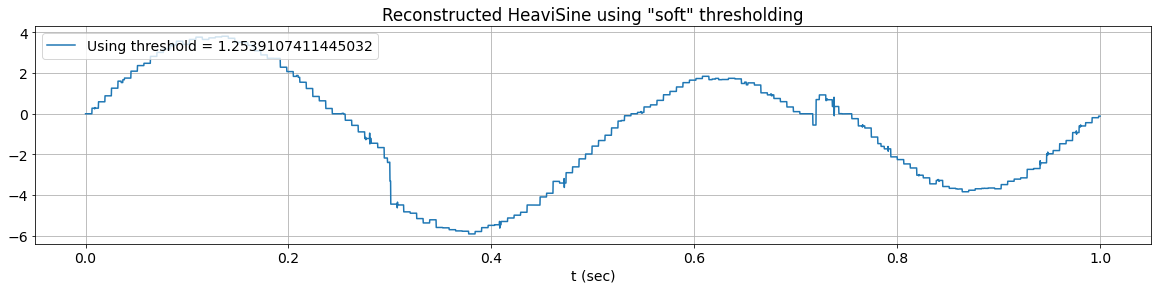

Mean Absolute Error using "soft" thresholding= 0.21519671863682532
SNR using "soft" thresholding = 38.206742610730565 dB


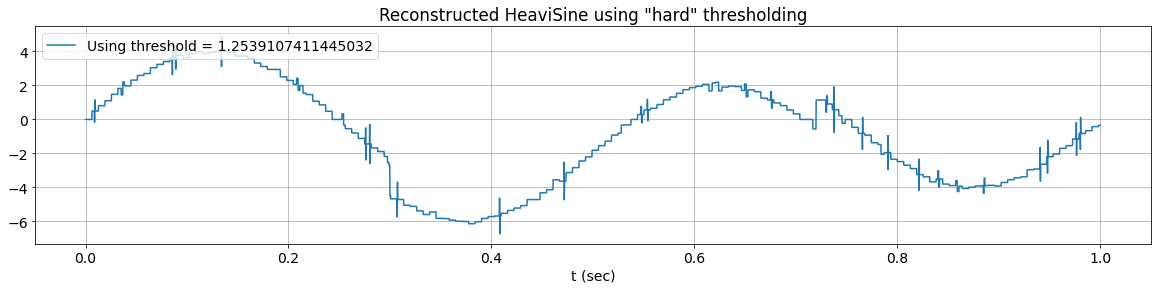

Mean Absolute Error using "hard" thresholding= 0.10249419841304758
SNR using "hard" thresholding = 33.15524282753151 dB


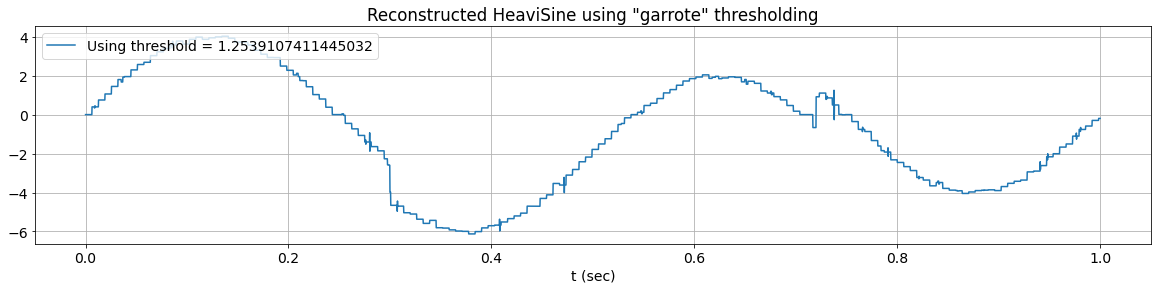

Mean Absolute Error using "garrote" thresholding= 0.09091783522805767
SNR using "garrote" thresholding = 45.19644265409075 dB


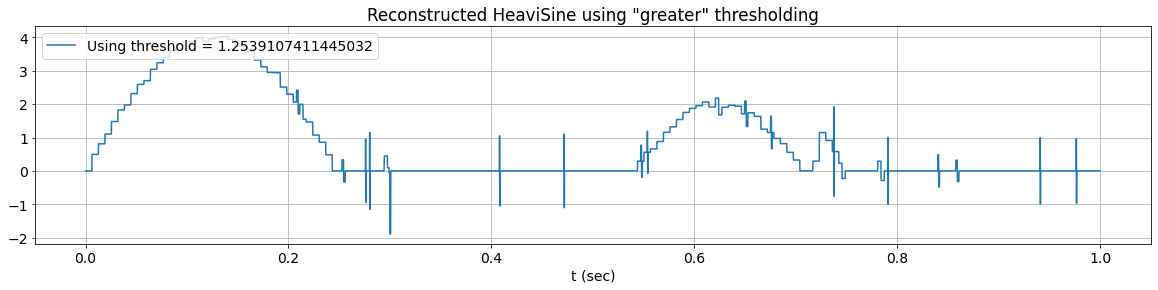

Mean Absolute Error using "greater" thresholding= 1.7624979100496638
SNR using "greater" thresholding = 1.0305367984588294 dB


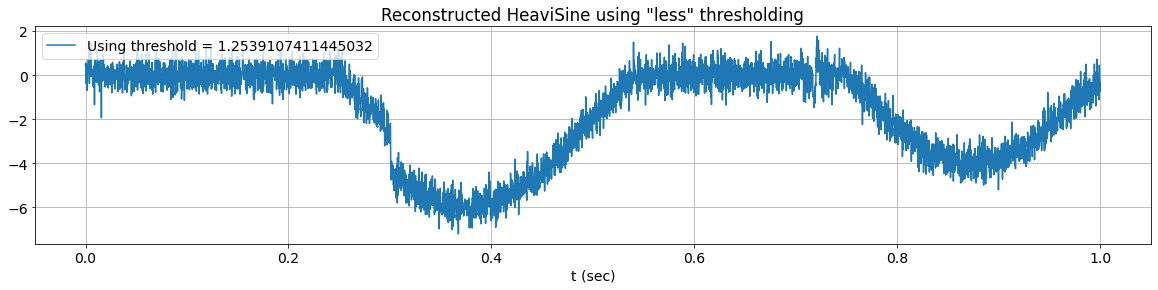

Mean Absolute Error using "less" thresholding= 1.084942724449091
SNR using "less" thresholding = 5.846411139554208 dB


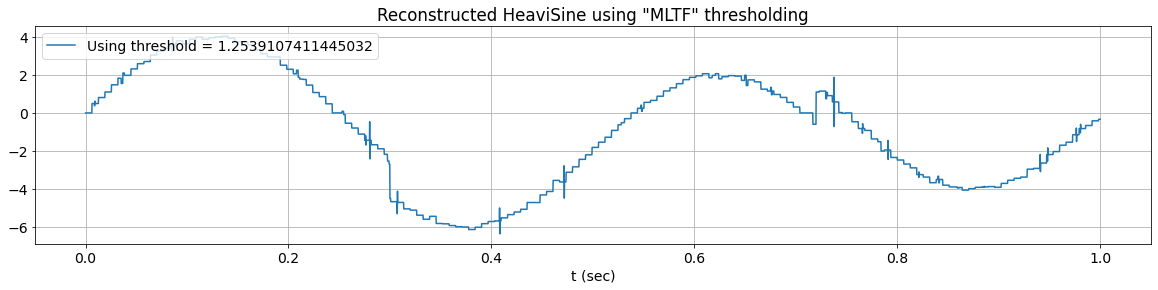

Mean Absolute Error using "MLTF" thresholding= 0.08995841497733775
SNR using "MLTF" thresholding = 38.206742610730565 dB


In [61]:
# WAVELET DECOMPOSITION , THRESHOLDING AND SIGNAL RECONSTRUCTION

def snr(s,sn):    # a function to calculate the SNR from the original and the noisy signal
  n=sn-s
  sig_pwr=np.array(s,dtype='int64')**2
  sig_avg_watts=np.mean(sig_pwr) 
  sig_avg_db = 10 * np.log10(sig_avg_watts) #signal power in dB
  noise_pwr=np.array(n,dtype='int64')**2
  noise_avg_watts=np.mean(noise_pwr) 
  noise_avg_db = 10 * np.log10(noise_avg_watts) #noise power in dB
  return sig_avg_db-noise_avg_db


def newfn(coeff,alpha,m,thr):   # calculating the value to replace for the original coefficient as proposed in the paper
  num=(alpha+1)*(thr**(m+1))
  den= (alpha * abs(coeff)**m) + (thr**m)
  return np.sign(coeff)*(abs(coeff)-(num/den))

def mltf(c,thr):      # MLTF = multi level threshold function
  alpha=0.45          # this function takes the original coefficients and returns the thresholded coefficients
  m=10
  L=len(c)
  c_hat=[]
  for j in range(L):
    x=np.ndarray(shape=np.shape(c[j]))
    for k in range(np.shape(c[j])[0]):
      if abs(c[j][k])>thr:
        x[k]=newfn(c[j][k],alpha,m,thr)
      else:
        x[k]=0
    c_hat.append(x)
  return c_hat

db1 = pywt.Wavelet('db1')
ca5,cd5,cd4,cd3,cd2,cd1=pywt.wavedec(list(noisy), db1,level=5)    # 5 level decomposition

c=[ca5,cd5,cd4,cd3,cd2,cd1]
sigma=np.std(noise)
K=N
threshold=np.sqrt((sigma**2) * 2 * np.log10(K))   # proposed method in paper for calculating the threshold
modes=['soft', 'hard', 'garrote', 'greater', 'less','MLTF']   # all the different modes in pywt + the proposed method MLTF

for mode in modes:
  c_hat=[]
  if mode=='MLTF':
    c_hat=mltf(c,threshold)
  else:
    for coeff in c:
      c_hat.append(pywt.threshold(data=coeff,value=threshold,mode=mode))

  heav_hat = pywt.waverec(c_hat,db1)
  plt.figure(figsize=(20,4))
  plt.rcParams.update({'font.size':14})
  plt.plot(t,heav_hat, label=f'Using threshold = {threshold}')
  plt.xlabel('t (sec)')
  plt.grid()
  plt.title(f'Reconstructed HeaviSine using "{mode}" thresholding')
  plt.legend(loc='upper left')
  plt.show()
  print(f'Mean Absolute Error using "{mode}" thresholding= {(np.sum(abs(heav-heav_hat)))/N}')
  print(f'SNR using "{mode}" thresholding = {snr(heav,heav_hat)} dB')   # showing the SNR  for the reconstructed signal


In the following thresholding techniques, there is improvement in the signal-to-noise ratio compared to the SNR for original signal and noisy signal (which is 15 dB):


*   Soft (38 dB)
*   Hard (33 dB)
*   Garotte (45 dB)
*   Multi-level Threshold Function (39 dB)







**3. Download the NASA’s Femto Bearing Dataset from here. This is a dataset
containing high frequency sensor data regarding accelerated degradation
of bearings
(a) Deconstruct the signal and smooth it out (remove high frequency
noise) by using a suitable threshold.
(b) Perform the same operation using Moving Average Filter and compare the results.**

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


nasa=pd.read_csv('/content/drive/MyDrive/IIT Guwahati/IITG_DigitalSignalProcessorsLab/FEMTO NASA dataset/temp_00001.csv',sep=';',header=None)

In [80]:
nasa.head()   # understanding the structure of the data

,0,1,2,3,4
0,9,11,37,6,67.094
1,9,11,37,7,67.094
2,9,11,37,8,67.126
3,9,11,37,9,67.126
4,9,11,38,0,67.157


In [81]:
df=nasa.iloc[:,4]
x=np.array(df)  # taking the last column as the data to filter

In [82]:
x

array([67.094, 67.094, 67.126, 67.126, 67.157, 67.157, 67.19 , 67.19 ,
       67.221, 67.221, 67.251, 67.251, 67.285, 67.285, 67.315, 67.315,
       67.348, 67.348, 67.378, 67.378, 67.41 , 67.41 , 67.44 , 67.44 ,
       67.47 , 67.47 , 67.498, 67.498, 67.528, 67.528, 67.557, 67.557,
       67.588, 67.588, 67.616, 67.616, 67.644, 67.644, 67.676, 67.676,
       67.703, 67.703, 67.731, 67.731, 67.761, 67.761, 67.788, 67.788,
       67.818, 67.818, 67.848, 67.848, 67.876, 67.876, 67.904, 67.904,
       67.933, 67.933, 67.964, 67.964, 67.991, 67.991, 68.021, 68.021,
       68.049, 68.049, 68.079, 68.079, 68.11 , 68.11 , 68.139, 68.139,
       68.172, 68.172, 68.198, 68.198, 68.225, 68.225, 68.249, 68.249,
       68.272, 68.272, 68.292, 68.292, 68.313, 68.313, 68.333, 68.333,
       68.354, 68.354, 68.373, 68.373, 68.395, 68.395, 68.418, 68.418,
       68.44 , 68.44 , 68.466, 68.466, 68.492, 68.492, 68.517, 68.517,
       68.544, 68.544, 68.569, 68.569, 68.595, 68.595, 68.621, 68.621,
      

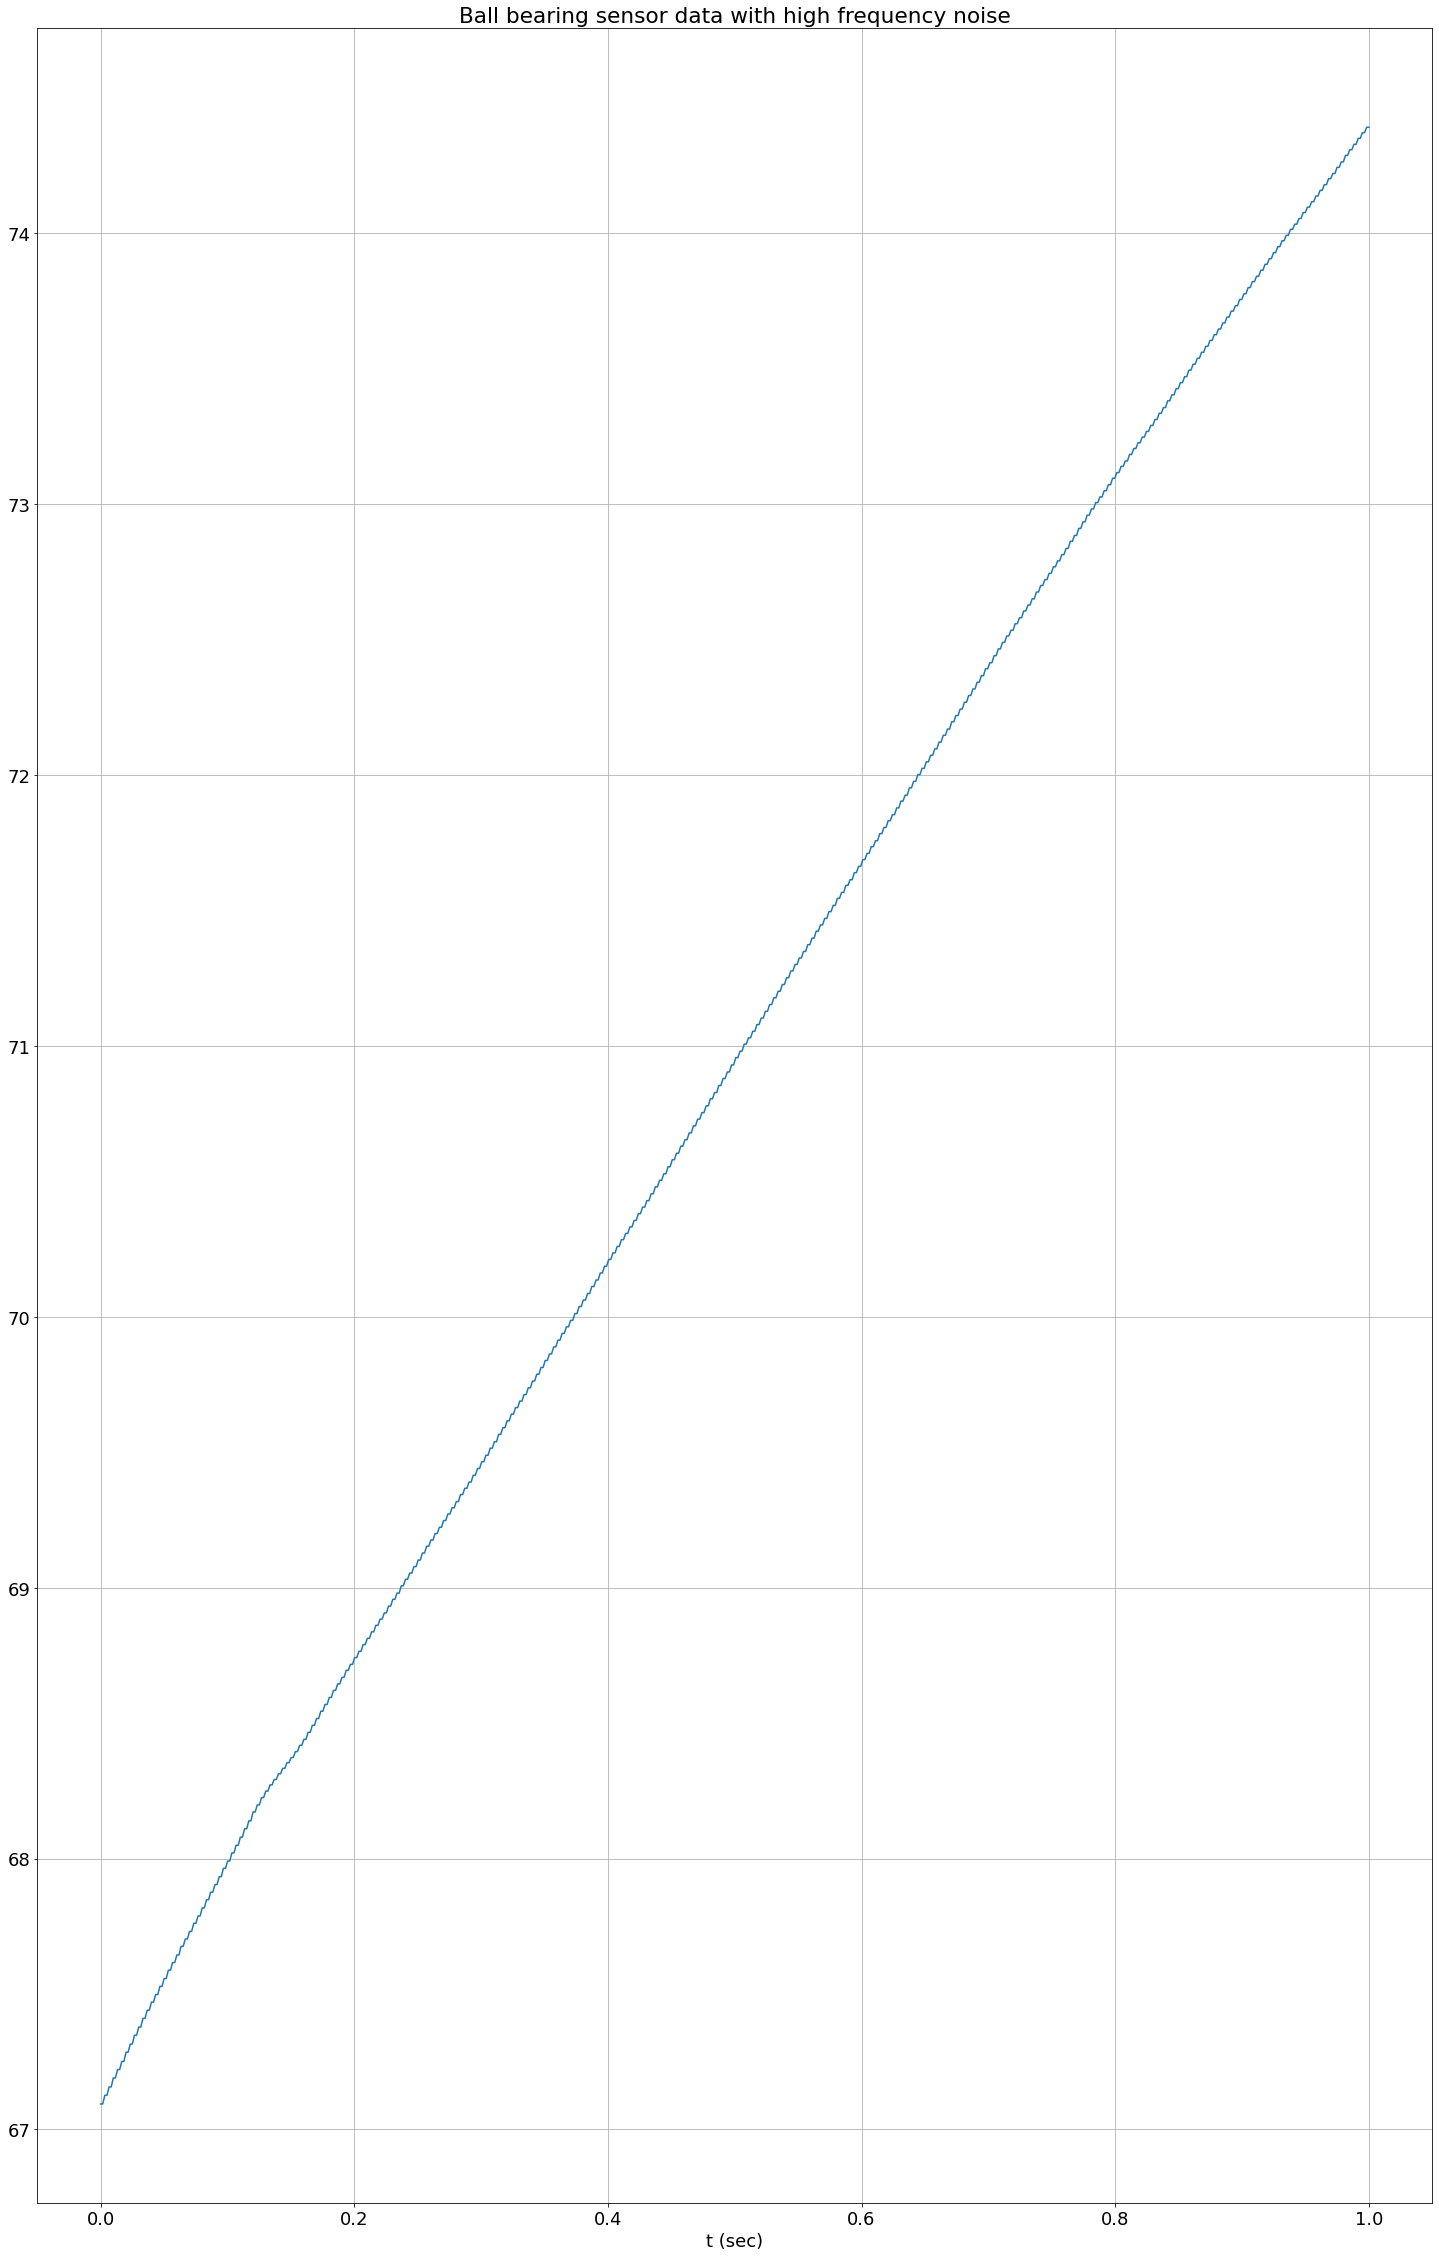

Standard deviation of the data = 2.102957883751677


In [83]:
t=np.linspace(0,1,np.shape(x)[0])
plt.figure(figsize=(25,40))
plt.rcParams.update({'font.size':18})
plt.plot(t,x)
plt.xlabel('t (sec)')
plt.grid()
plt.title(f'Ball bearing sensor data with high frequency noise')
plt.show()
print(f'Standard deviation of the data = {np.std(x)}')

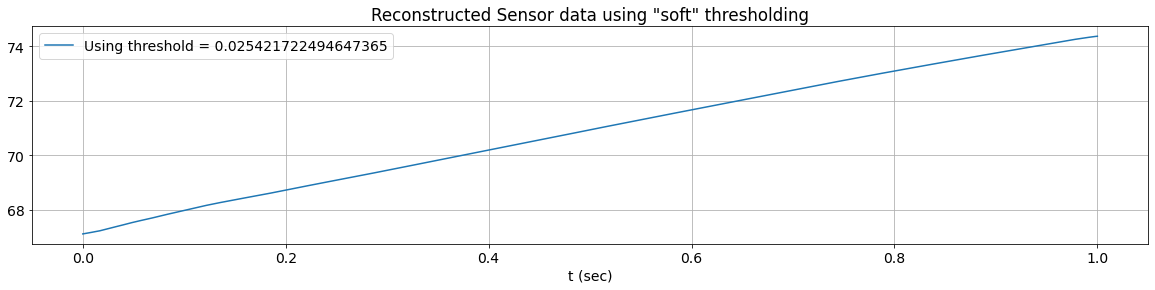

Standard deviation of the data = 2.1028007550865055


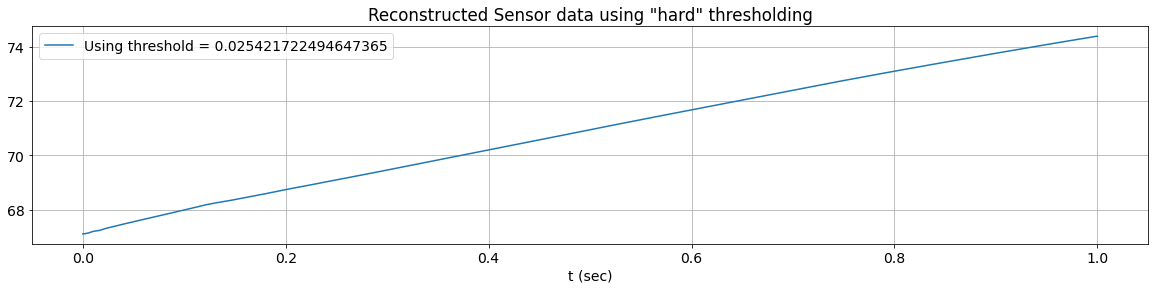

Standard deviation of the data = 2.1028654032747496


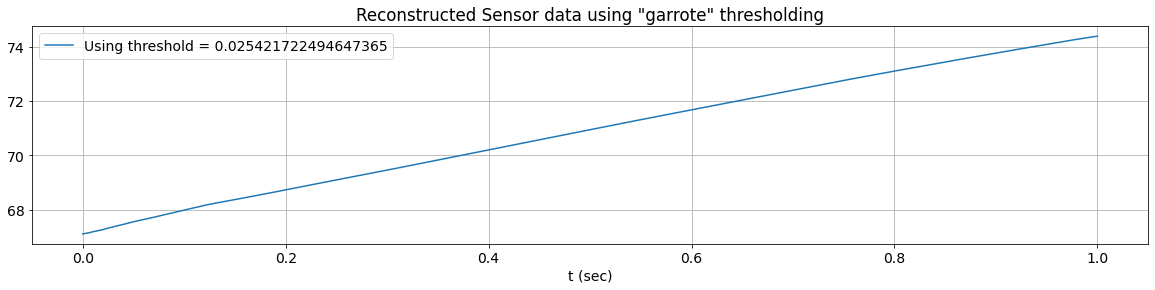

Standard deviation of the data = 2.102789239937878


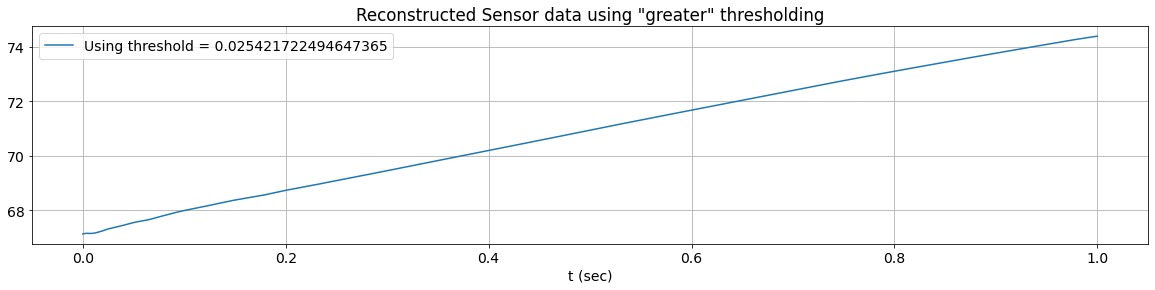

Standard deviation of the data = 2.1030182210876838


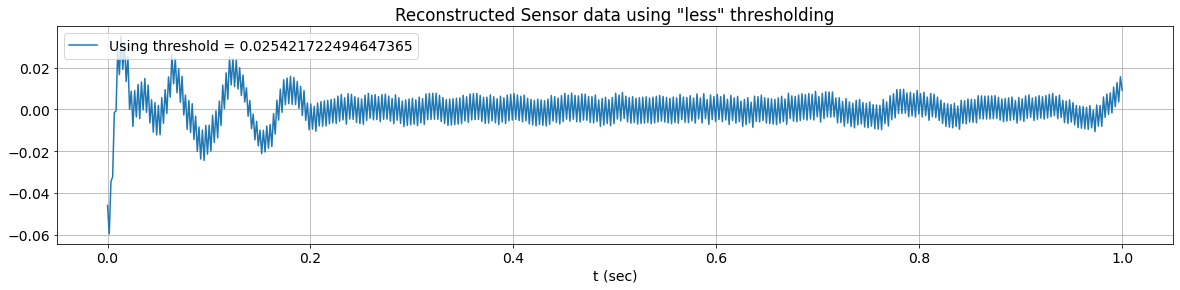

Standard deviation of the data = 0.00879342514140205


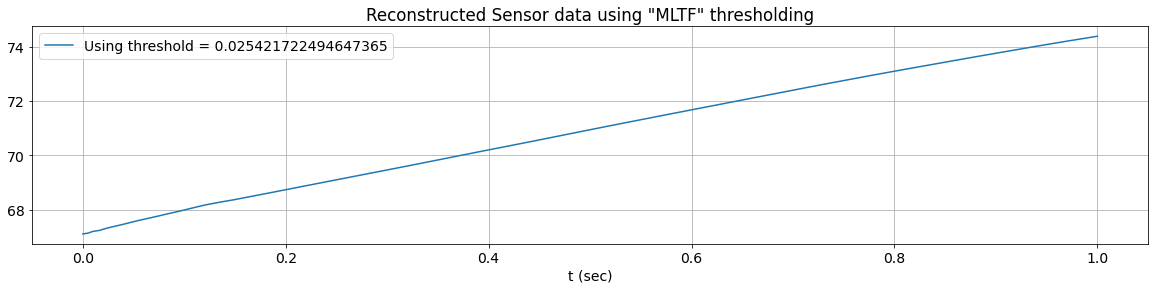

Standard deviation of the data = 2.1028473809340875


In [84]:
# APPLYING DIFFERENT THRESHOLD TECHNIQUES TO FILTER THE DATA

import pywt 

db4 = pywt.Wavelet('db4') # using Daubechies4 mother wavelet
ca5,cd5,cd4,cd3,cd2,cd1=pywt.wavedec(list(x), db4,level=5)    # 5 level decomposition
c=[ca5,cd5,cd4,cd3,cd2,cd1]
#ca,cd=pywt.dwt(list(x), db4)
#c=[ca,cd]

N=np.shape(x)[0]
detail=[]
for j in range(1,len(c)):             #collecting the detail coefficients for calculating sigma for threshold
  for k in range(np.shape(c[j])[0]):
    detail.append(c[j][k])
detail=np.abs(np.array(detail))

sigma=np.median(detail)/0.6745
K=N #number of samples
threshold=np.sqrt((sigma**2) * 2 * np.log10(K)) # threshold using proposed method
modes=['soft', 'hard', 'garrote', 'greater', 'less','MLTF']

for mode in modes:    # thresholding using different modes as given in the above list
  c_hat=[]
  if mode=='MLTF':
    c_hat=mltf(c,threshold)
  else:
    for coeff in c:
      c_hat.append(pywt.threshold(data=coeff,value=threshold,mode=mode))

  x_hat = pywt.waverec(c_hat,db4)
  #x_hat=pywt.idwt(c_hat[0],c_hat[1],db4)
  plt.figure(figsize=(20,4))
  plt.rcParams.update({'font.size':14})
  plt.plot(t,x_hat, label=f'Using threshold = {threshold}')
  plt.xlabel('t (sec)')
  plt.grid()
  plt.title(f'Reconstructed Sensor data using "{mode}" thresholding')
  plt.legend(loc='upper left')
  plt.show()
  print(f'Standard deviation of the data = {np.std(x_hat)}')


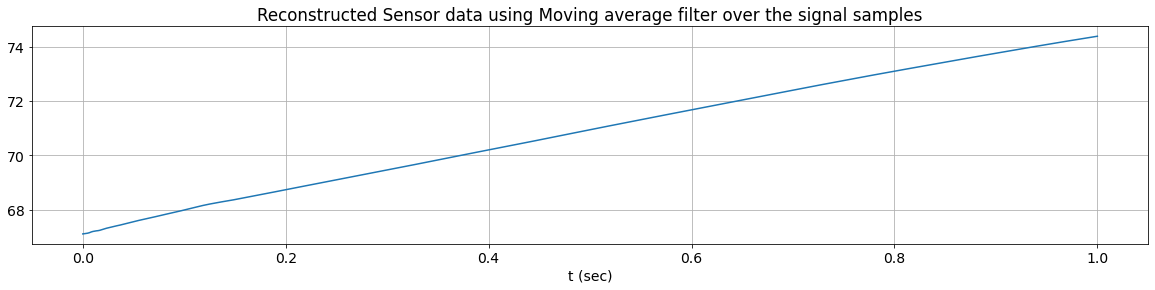

Standard deviation of the data = 1.9300506273188935


In [88]:
# APPLYING THE MOVING AVERAGE FILTER

def MovAvg(x,win_len):  # takes in the sequence and window length
  x=np.array(x)         # returns the filtered sequence
  n=win_len
  filt=[]
  sum=0
  for i in range(n):
    sum=sum+x[i]
  filt.append(sum)
  for i in range(n,np.shape(x)[0]):
    sum=sum+x[i]-x[i-n]
    filt.append(sum)
  #filt=filt+[0]*(n-1)    # currently the sequence size is decreasing. This line appends necessary zeros to make the 
  return np.array(filt)/n   # input and output size same

win_len=50    # window length
filt2=MovAvg(x,win_len)
plt.figure(figsize=(20,4))
plt.rcParams.update({'font.size':14})
plt.plot(t,x_hat)
plt.xlabel('t (sec)')
plt.grid()
plt.title(f'Reconstructed Sensor data using Moving average filter over the signal samples')
plt.show()
print(f'Standard deviation of the data = {np.std(filt2)}')


Since we do not have any idea about the original signal, we cannot find the SNR. 

After plotting the data, by observation we assume the original signal is a straight line. We compare the standard deviation of the original signal with the signal filtered by wavelet denoising and moving average filter. 

From the standard deviation values, we can see both are giving similar values almost. However, the moving average filter is giving slightly better results. And it can be improved using a bigger window length. 

Similar modifications may also be possible in wavelet denoising, like adjusting the mother wavelet, threshold, level of decomposition, etc.